# GANta Claus

This year, for our lab Christmas dinner I again extended [my script](https://gist.github.com/jcboyd/71806537db2237ae527b78a7b261446c) for sending the Secret Santa emails (last year I added an RNN which wrote dubious Christmas poetry). It seemed fitting in my final year to incorporate a GAN into the charade. Thus was born GANta Claus.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import numpy as np
import matplotlib.pyplot as plt

## Data scraping

I'm not going to show how I did this, but I basically raided a large image hosting website using `requests` and `BeautifulSoup`. The website in question seemed prepared for such pillaging, and a number of workarounds were required, in particular, impersonating a web browser by setting the user-agent parameter in the GET header:

`headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 \
                           (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
r = requests.get(url, headers=headers)`

After 24 hours I had $\sim 100$K stock photos relating to the search term "santa claus". The data was quite heterogeneous, and it seemed clear I needed a sophisticated cropping strategy to pick out the santas from occassionally broad festive scenes.

## Cropping strategy - Faster R-CNN

Thanks to the `PyTorch` community, it could not be easier to get started with a state-of-the-art object detection system. The pretrained Faster R-CNN[1] conveniently models a "person" class. I Fully recommend reading the R-CNN "series" (R-CNN, Fast R-CNN, Faster R-CNN, Mask R-CNN) to anyone new to deep learning, you can learn a lot about how neural systems are engineered. I used the system R-CNN straight out of the box, and found it gave very workable results, even for cartoon Santas (Faster R-CNN is trained on natural images). Below I demonstrate the procedure for a single image.

[1] (Ren, S., He, K., Girshick, R., & Sun, J. (2015). Faster r-cnn: Towards real-time object detection with region proposal networks. In Advances in neural information processing systems (pp. 91-99).)

In [2]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
from skimage.io import imread
from torchvision import transforms

# where the image stash is kept
base_dir = '/Users/jcboyd/Desktop/img'
# pick out arbitrary image
img_path = os.path.join(base_dir, 'santas.jpg')
# truncate watermark ;-)
img = imread(img_path)[:-20]

# prepare image for PyTorch
preprocess = transforms.Compose([
    transforms.ToTensor()])

img = preprocess(img).to(device)

In [4]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

model = fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model = model.eval()

pred = model([img])[0]

For this demonstration I rather use an [open source image](https://en.wikipedia.org/wiki/Santa_Claus#/media/File:Liverpool_Santa_Dash_2009.jpg) from Wikipedia. Note that this image is both larger and vastly more populated than the typical image from my dataset, but it does showcase the power of Faster R-CNN.

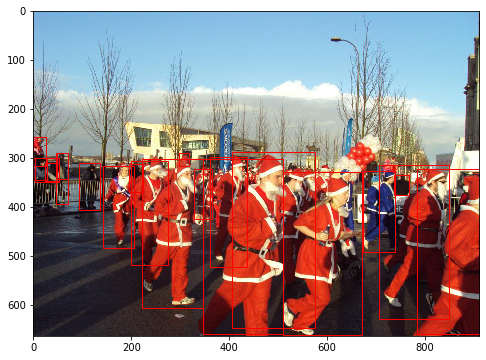

In [5]:
from matplotlib.patches import Rectangle

# By inspection, this probability threshold seems a good compromise on the dataset
THRESHOLD = 0.5

fig, ax = plt.subplots(figsize=(8, 8))

for i in range(len(pred['labels'])):

    x1, y1, x2, y2 = map(int, pred['boxes'][i])
    label = COCO_INSTANCE_CATEGORY_NAMES[pred['labels'][i]]
    score = pred['scores'][i]

    if score > THRESHOLD and label == 'person':

        rect = Rectangle((x1, y1), x2-x1, y2-y1,
                         linewidth=1, edgecolor='r',
                         facecolor='none')
        ax.add_patch(rect)

ax.imshow(img.permute(1, 2, 0))

## Load detections

Without configuring PyTorch for multiple GPU processing, it took about 2 hours to process the dataset which amounts to 10-20 FPS, which seems to be in the right ballpark (the paper reports 5 FPS, but that was 2015, and our images are probably smaller than theirs). The bouding boxes were used to directly crop santas, which were then downsampled to CIFAR size $32 \times 32 \times 3$.

In [6]:
from skimage.io import imread_collection

base_dir = '/Users/jcboyd/Desktop/crops'
file_names = os.listdir(base_dir)

all_crops = np.stack([imread(os.path.join(base_dir, file_name))
                      for file_name in file_names])

You can see how diverse this dataset is. The person detection has worked quite well, but even if all santas are people, not all people are santas! Note that in practice a higher probability threshold would be used, and non-maximum suppression would eliminate many sub-optimal bounding boxes, but I wanted to include some of the many cartoon santas in the final dataset. We need a further filtering strategy to pick out the best santas.

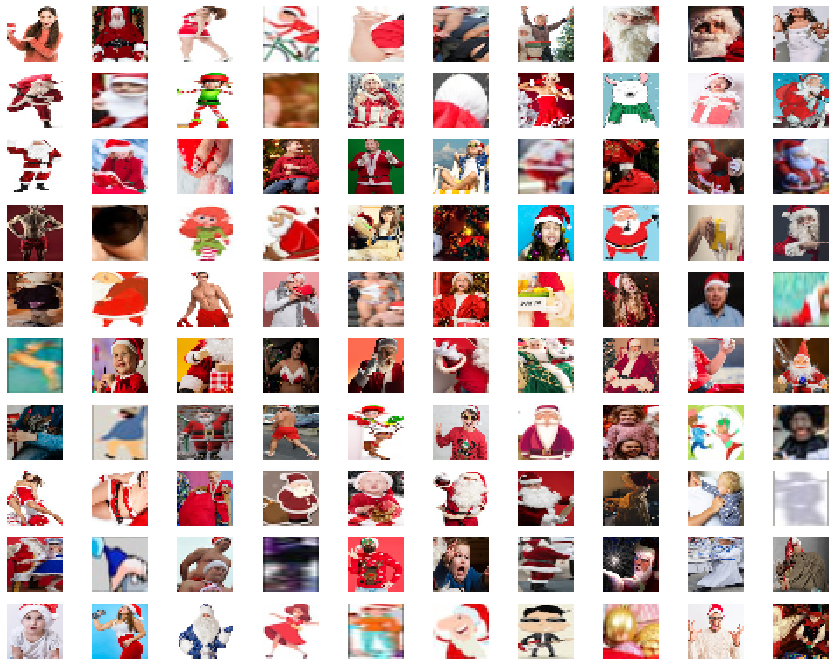

In [7]:
fig = plt.figure(figsize=(15, 12))

for i in range(100):
    crop = all_crops[np.random.choice(all_crops.shape[0])]
    ax = fig.add_subplot(10, 10, 10 * (i // 10) + i % 10 + 1)
    ax.imshow(crop)
    ax.axis('off')

## Extract features

First we need a better representation. A deep pretrained CNN can give us a nice discriminative "CNN Code" respresentation. Pretrained classifiers could not be easier with `Keras`, and ResNet50[2] is as good as any.

[2] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

In [8]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

input_imgs = np.stack([preprocess_input(crop) for crop in all_crops])

# load pretrained model without classification layers
model = ResNet50(include_top=False, weights='imagenet')

codes = model.predict(input_imgs, verbose=True)[:, 0, 0, :]
print(codes.shape)

/Users/jcboyd/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


99427/99427 [==============================] - 311s 3ms/step
(99427, 2048)


## Cluster data

Now I cluster the CNN codes. The idea is to retain a few reliable clusters and drop the rest. However, even K-means, one of the fastest `sklearn` clustering algorithms takes ages to converge, so I resort to `MiniBatchKMeans` (the SGD of K-means). By trial and error, 10 clusters seems a code fit.

In [9]:
import time
from sklearn.cluster import MiniBatchKMeans

nb_clusters = 10
start_time = time.time()

kmeans = MiniBatchKMeans(n_clusters=nb_clusters, init='k-means++', max_iter=1000).fit(codes)

end_time = time.time()
print('Fitting time: %.02f seconds' % (end_time - start_time))

Fitting time: 1.71 seconds


Just to get an idea, I plot the clustering output with Umap[3]. It seems that K-Means has simply partitioned manifold rather than discovering any standout clusters.

[3] McInnes, L., Healy, J., & Melville, J. (2018). Umap: Uniform manifold approximation and projection for dimension reduction. arXiv preprint arXiv:1802.03426.

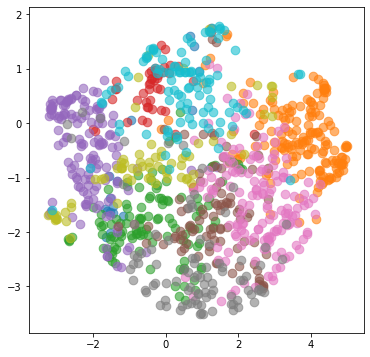

In [10]:
import umap.umap_ as umap

idx = np.random.randint(codes.shape[0], size=1000)

embedding_model = umap.UMAP(n_components=2)
embedding_feats = embedding_model.fit(codes[idx]).embedding_

fig, ax = plt.subplots(figsize=(6, 6))

unique_labels = np.unique(kmeans.labels_[idx])

for label in unique_labels:

    labels_idx = kmeans.labels_[idx] == label
    ax.scatter(embedding_feats[labels_idx, 0],
                embedding_feats[labels_idx, 1], alpha=0.6, s=75)

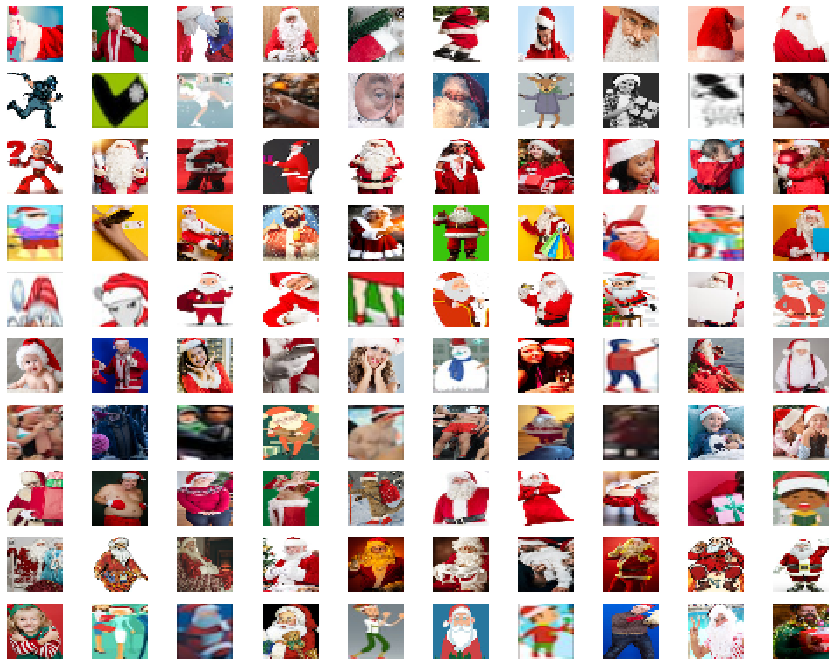

In [11]:
fig = plt.figure(figsize=(15, 12))

for label in range(nb_clusters):
    label_idx = np.nonzero(kmeans.labels_ == label)[0]
    for i in range(10):
        crop = all_crops[np.random.choice(label_idx)]
        ax = fig.add_subplot(nb_clusters, 10, label * 10 + i + 1)
        ax.imshow(crop)
        ax.axis('off')

There is still plenty of confusion, but here (counting from zero) I would take clusters $2$, $4$, and $8$. We are certainly sacrificing a lot of good data, but at least the clustering allows us to eliminate a lot of garbage as in clusters $1$ and $6$.

In [12]:
labels = kmeans.labels_
idx_santa = (labels == 2) + (labels == 4) + (label == 8)
x_train = all_crops[idx_santa]
print(x_train.shape)

## Visualise ground truth

Now it's time to train GANta. First we visualise our filtered dataset. There are still some errors, but it should be good enough.

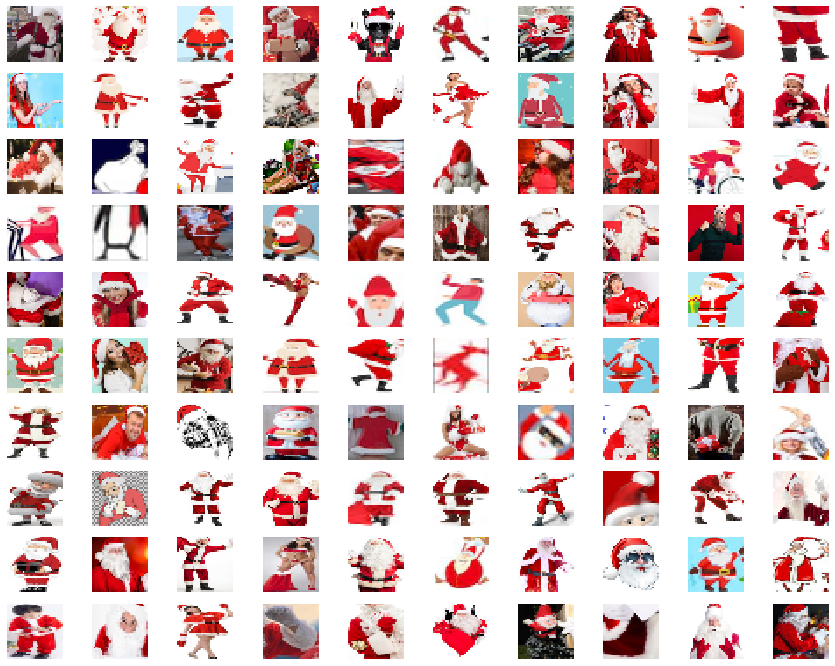

In [13]:
fig = plt.figure(figsize=(15, 12))

for i in range(100):
    crop = x_train[np.random.choice(x_train.shape[0])]
    ax = fig.add_subplot(10, 10, 10 * (i // 10) + i % 10 + 1)
    ax.imshow(crop)
    ax.axis('off')

## Configure GAN

The suitable choice for this problem is a simple DCGAN[4], that is, deep convolutional generator and discriminator networks. Here again I use `Keras`, as I already had such a model implemented.

[4] Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.

In [14]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, Activation, BatchNormalization
from keras.layers import MaxPooling2D, UpSampling2D, Reshape, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

def DCGAN(img_shape, noise_dim):

    # Generator
    generator = Sequential()

    s = img_shape[0] // 4
    nb_channels = img_shape[-1]

    generator.add(Dense(128 * s * s, input_dim=noise_dim,
                  kernel_initializer='glorot_uniform'))
    generator.add(BatchNormalization(momentum=0.9))
    generator.add(Activation('relu'))

    generator.add(Reshape((s, s, 128)))

    generator.add(UpSampling2D(size=(2, 2)))

    generator.add(Conv2D(16, kernel_size=(3, 3), padding='same',
                  kernel_initializer='glorot_uniform'))
    generator.add(BatchNormalization(momentum=0.9))
    generator.add(Activation('relu'))

    generator.add(Conv2D(16, kernel_size=(3, 3), padding='same',
                  kernel_initializer='glorot_uniform'))
    generator.add(BatchNormalization(momentum=0.9))
    generator.add(Activation('relu'))

    generator.add(UpSampling2D(size=(2, 2)))

    generator.add(Conv2D(32, kernel_size=(3, 3), padding='same',
                  kernel_initializer='glorot_uniform'))
    generator.add(BatchNormalization(momentum=0.9))
    generator.add(Activation('relu'))

    generator.add(Conv2D(nb_channels, kernel_size=(5, 5), padding='same',
                  activation='tanh', kernel_initializer='glorot_uniform'))

    # Discriminator
    discriminator = Sequential()

    discriminator.add(Conv2D(16, kernel_size=(3, 3),
                      padding='same', input_shape=img_shape,
                      kernel_initializer='glorot_uniform'))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    discriminator.add(Conv2D(32, kernel_size=(3, 3),
                      padding='same', kernel_initializer='glorot_uniform'))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    discriminator.add(Flatten())

    discriminator.add(Dense(128, kernel_initializer='glorot_uniform'))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(1, activation='sigmoid',
                      kernel_initializer='glorot_uniform'))

    return generator, discriminator

noise_dim = 100
gen_noise = np.random.randn(100, noise_dim)

generator, discriminator = DCGAN(x_train.shape[1:], noise_dim)

adam = Adam(lr=0.0002, beta_1=0.5, decay=1e-6)

discriminator.compile(loss='binary_crossentropy', optimizer=adam)

def set_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

set_trainable(discriminator, False)

# Create end-to-end model
input_noise = Input(shape=(noise_dim,))

x = generator(input_noise)
d_output = discriminator(x)

gan = Model(inputs=input_noise, outputs=d_output)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 32, 32, 3)         888227    
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 267489    
Total params: 1,155,716
Trainable params: 871,715
Non-trainable params: 284,001
_________________________________________________________________


## Train GAN

Normally I would record some generator samples after each epoch, but I save it for the end here.

In [15]:
# normalise to [-1, 1] -- crucial for the tanh activation
x_train = x_train / 127.5 - 1

nb_epochs = 200
batch_size = 128
nb_batch = x_train.shape[0] // batch_size

for epoch in range(nb_epochs):

    for _ in range(nb_batch):

        # Get a random set of input noise and images
        noise = np.random.randn(batch_size // 2, noise_dim)
        idx = np.random.randint(x_train.shape[0], size=batch_size // 2)
        x_batch = x_train[idx]

        # Generate fake images
        g_batch = generator.predict(noise)
        x_batch = np.concatenate([x_batch, g_batch])
        
        # Labels (smoothed) for generated and real data
        d_batch = np.hstack([0.7 + 0.5 * np.random.rand(batch_size // 2),
                             0.3 * np.random.rand(batch_size // 2)])

        # Train discriminator
        set_trainable(discriminator, True)
        loss_d = discriminator.train_on_batch(x_batch, d_batch)

        # Train generator
        noise = np.random.randn(batch_size, noise_dim)
        d_batch = np.ones(batch_size)
        set_trainable(discriminator, False)
        loss_g = gan.train_on_batch(noise, d_batch)

    generator.save_weights('./weights/generator.h5')

    if epoch % 20 == 0:
        print('Epoch %d : %.04f %.04f' % (epoch, loss_d, loss_g))

Epoch 000 : 0.5594 0.9132
Epoch 020 : 0.6310 0.7889
Epoch 040 : 0.6177 0.6935
Epoch 060 : 0.6294 0.7413
Epoch 080 : 0.6074 0.8393
Epoch 100 : 0.5685 0.8726
Epoch 120 : 0.5489 1.2172
Epoch 140 : 0.5669 0.9955
Epoch 160 : 0.5186 1.1390
Epoch 180 : 0.5198 1.2137


## Sample generator

Now the fun part: sampling Gantas. Clearly the network has learned a lot, and at least from afar the samples looking very reasonable. It will require a larger GAN and/or more data to improve this outcome. It would also be interesting to increase the resolution, as $32 \times 32$ is a drastic reduction. Still, not bad for a Christmas farce.

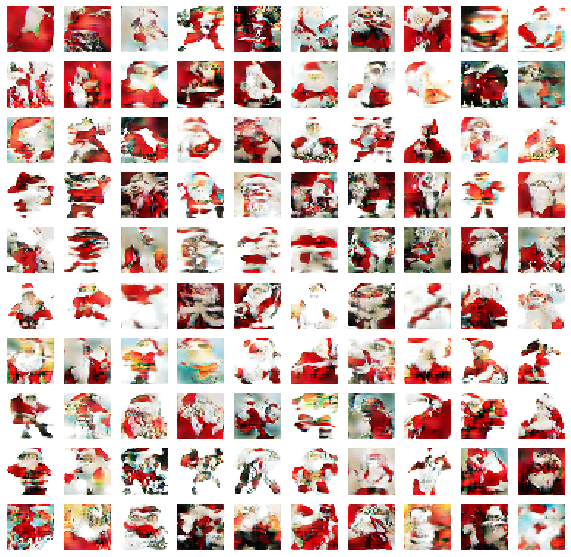

In [16]:
generator, _ = DCGAN(x_train.shape[1:], noise_dim)
generator.load_weights('./weights/generator.h5')

samples = generator.predict(gen_noise)

fig = plt.figure(figsize=(10, 10))

for i in range(samples.shape[0]):
    ax = fig.add_subplot(10, 10, 10 * (i // 10) + i % 10 + 1)
    sample = np.clip((samples[i, ...] + 1) / 2, 0, 1)  # denormalise
    ax.imshow(sample, cmap='Greys_r')
    ax.axis('off')

*Say Hi to GANta Claus!*

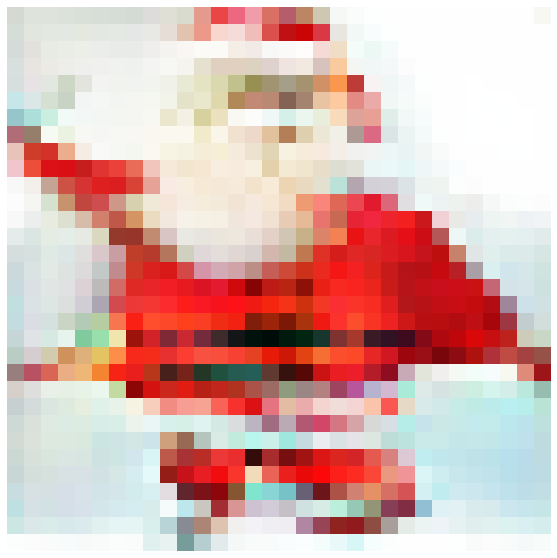

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

sample = generator.predict(np.random.randn(1, noise_dim))
sample = np.clip((sample[0] + 1) / 2, 0, 1)
ax.imshow(sample)
ax.axis('off')